| **Chapter**                   | 9:  Agent-based modeling                       |
| ----------------------------- |------------------------------------------------|
| **Computational Note**        | 9.x: SI-SIRD epidemic competition              |
| **Package prerequisites**     | [Mesa](https://mesa.readthedocs.io/en/latest/) |


# Healthcare capacity contingent mortality (HCCM)

In [1]:
import numpy as np
import pandas as pd
from mesa import Agent, Model
from mesa.time import RandomActivation
from mesa.space import NetworkGrid
from mesa.datacollection import DataCollector
from matplotlib import pyplot as plt
import networkx as nx
import json
from scipy import stats
import enum

COLORS = {"S": "#2f4b7c",
          "E": "#ffa600",
          "I": "#f95d6a",
          "R": "#a05195",
          "D": "#003f5c",
          "C": "#ff7c43",
          "X": "#665191",
          "Y": "#d45087"}

In [2]:
%load_ext watermark
%watermark --iversions -v -a "Chris von Csefalvay" -gu "chrisvoncsefalvay" -p mesa

Author: Chris von Csefalvay

Github username: chrisvoncsefalvay

Python implementation: CPython
Python version       : 3.10.2
IPython version      : 8.4.0

mesa: 0.9.0

networkx  : 2.8.4
json      : 2.0.9
matplotlib: 3.5.2
pandas    : 1.4.2
numpy     : 1.21.6
scipy     : 1.8.1



In [3]:
class State(enum.IntEnum):
    SUSCEPTIBLE = 0
    EXPOSED = 1
    INFECTED = 2
    RECOVERED = 3
    VACCINATED = 4
    DECEASED = 5

In [4]:
class Person(Agent):
    def __init__(self, uid, model):
        super().__init__(uid, model)
        
        # based on US population
        self.age = stats.norm.rvs(38.5, 20)
        
        # Naive start
        self.state = State.SUSCEPTIBLE
        
        self.time_at_infection = 0
        self.time_at_induction_of_immunity = None
        self.is_hospitalised = False

    def contact_event(self):
        neighbourhood = self.model.grid.get_neighbors(self.pos, include_center=False)
        susceptible_neighbourhood = [agent for agent in self.model.grid.get_cell_list_contents(neighbourhood) if agent.state is State.SUSCEPTIBLE]

        for neighbour in susceptible_neighbourhood:
            if np.random.rand() < model.beta:
                neighbour.state = State.EXPOSED

    def status_update(self):
        if self.state == State.EXPOSED:
            if self.model.schedule.time - self.time_at_infection >= model.latency_period.rvs():
                self.state = State.INFECTED
        
        if self.state == State.INFECTED:
            if self.model.schedule.time - self.time_at_infection >= model.latency_period.rvs() + model.recovery_period.rvs():
                if np.random.rand() < model.CFR:
                    self.state = State.DECEASED
                else:
                    self.state = State.RECOVERED
                    self.time_at_induction_of_immunity = self.model.schedule.time

        if np.random.rand() < model.base_mortality_rate:
            self.state = State.DECEASED

        if self.state == State.RECOVERED:
            if self.model.schedule.time - self.time_at_induction_of_immunity > self.model.duration_of_immunity.rvs():
                self.state = State.SUSCEPTIBLE

        if self.state == State.SUSCEPTIBLE:
            neighbourhood = self.model.grid.get_cell_list_contents(self.model.grid.get_neighbors(self.pos, include_center=False))

            # Simple majority voting quorum sensing
            vaccinated_neighbourhood = [i for i in neighbourhood if i.state == State.VACCINATED]

            if len(neighbourhood) == 0:
                quorum = 0
            else:
                quorum = len(vaccinated_neighbourhood)/len(neighbourhood)

            if np.random.rand() < self.model.base_vaccination_rate + int(quorum >= 0.5) * self.model.homophily_factor_of_vaccination:
                self.state = State.VACCINATED
                self.time_at_induction_of_immunity = self.model.schedule.time

        if self.state == State.VACCINATED:
            if self.model.schedule.time - self.time_at_induction_of_immunity > self.model.duration_of_vaccine_induced_immunity.rvs():
                self.state = State.SUSCEPTIBLE
        
    def step(self):
        self.status_update()
        self.contact_event()
    

    def toJSON(self):        
        key = self.unique_id
        return json.dumps(key, default=lambda o: o.__dict__, sort_keys=True, indent=4)

In [5]:
class NetworkInfectiousDiseaseModel(Model):

    def __init__(self, 
                 nodes=50, 
                 mean_degree=3,
                 latency_period_mu=5,
                 latency_period_sigma=2,
                 recovery_period_mu=14,
                 recovery_period_sigma=5,
                 beta=0.001,
                 CFR=0.05,
                 base_mortality_rate=0.000125,
                 I0=0.005,
                 duration_of_immunity_mu=90,
                 duration_of_immunity_sigma=14,
                 base_vaccination_rate=0.0007,
                 duration_of_vaccine_induced_immunity_mu=90,
                 duration_of_vaccine_induced_immunity_sigma=7,
                 homophily_factor_of_vaccination=3,
                 hospitalisation_fraction=0.2,
                 hospital_capacity=200):
                     
        self.N_agents = nodes
        self.latency_period = stats.halfnorm(latency_period_mu, latency_period_sigma)
        self.recovery_period = stats.halfnorm(recovery_period_mu, recovery_period_sigma)
        self.beta = beta
        self.CFR = CFR
        self.base_mortality_rate = base_mortality_rate
        self.duration_of_immunity = stats.halfnorm(duration_of_immunity_mu, duration_of_immunity_sigma)
        self.base_vaccination_rate = base_vaccination_rate
        self.duration_of_vaccine_induced_immunity = stats.halfnorm(duration_of_vaccine_induced_immunity_mu, duration_of_vaccine_induced_immunity_sigma)
        self.homophily_factor_of_vaccination = homophily_factor_of_vaccination
        self.hospitalisation_fraction = hospitalisation_fraction
        self.hospital_capacity = 200

        self.graph = nx.erdos_renyi_graph(n=self.N_agents, p=mean_degree/self.N_agents)
        self.grid = NetworkGrid(self.graph)

        self.schedule = RandomActivation(self)
        self.running = True

        for idx, node in enumerate(self.graph.nodes()):
            agent = Person(uid=idx + 1, model=self)
            self.schedule.add(agent)
            self.grid.place_agent(agent, node)

            if np.random.rand() < I0:
                agent.state = State.INFECTED

        self.datacollector = DataCollector(agent_reporters={"State": "state"})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

    def to_df(self):
        state_profile = self.datacollector.get_agent_vars_dataframe()
        output_df = pd.pivot_table(state_profile.reset_index(), 
                       index="Step", 
                       columns="State", 
                       aggfunc=np.size, 
                       fill_value=0)
        output_df.columns = [i.title() for i in State.__dict__.get("_member_names_")]
        return output_df

In [7]:
pop=10000
steps=60

model_1 = NetworkInfectiousDiseaseModel(pop, base_vaccination_rate=)

for i in range(steps):
    model.step()

model_results = model.to_df()

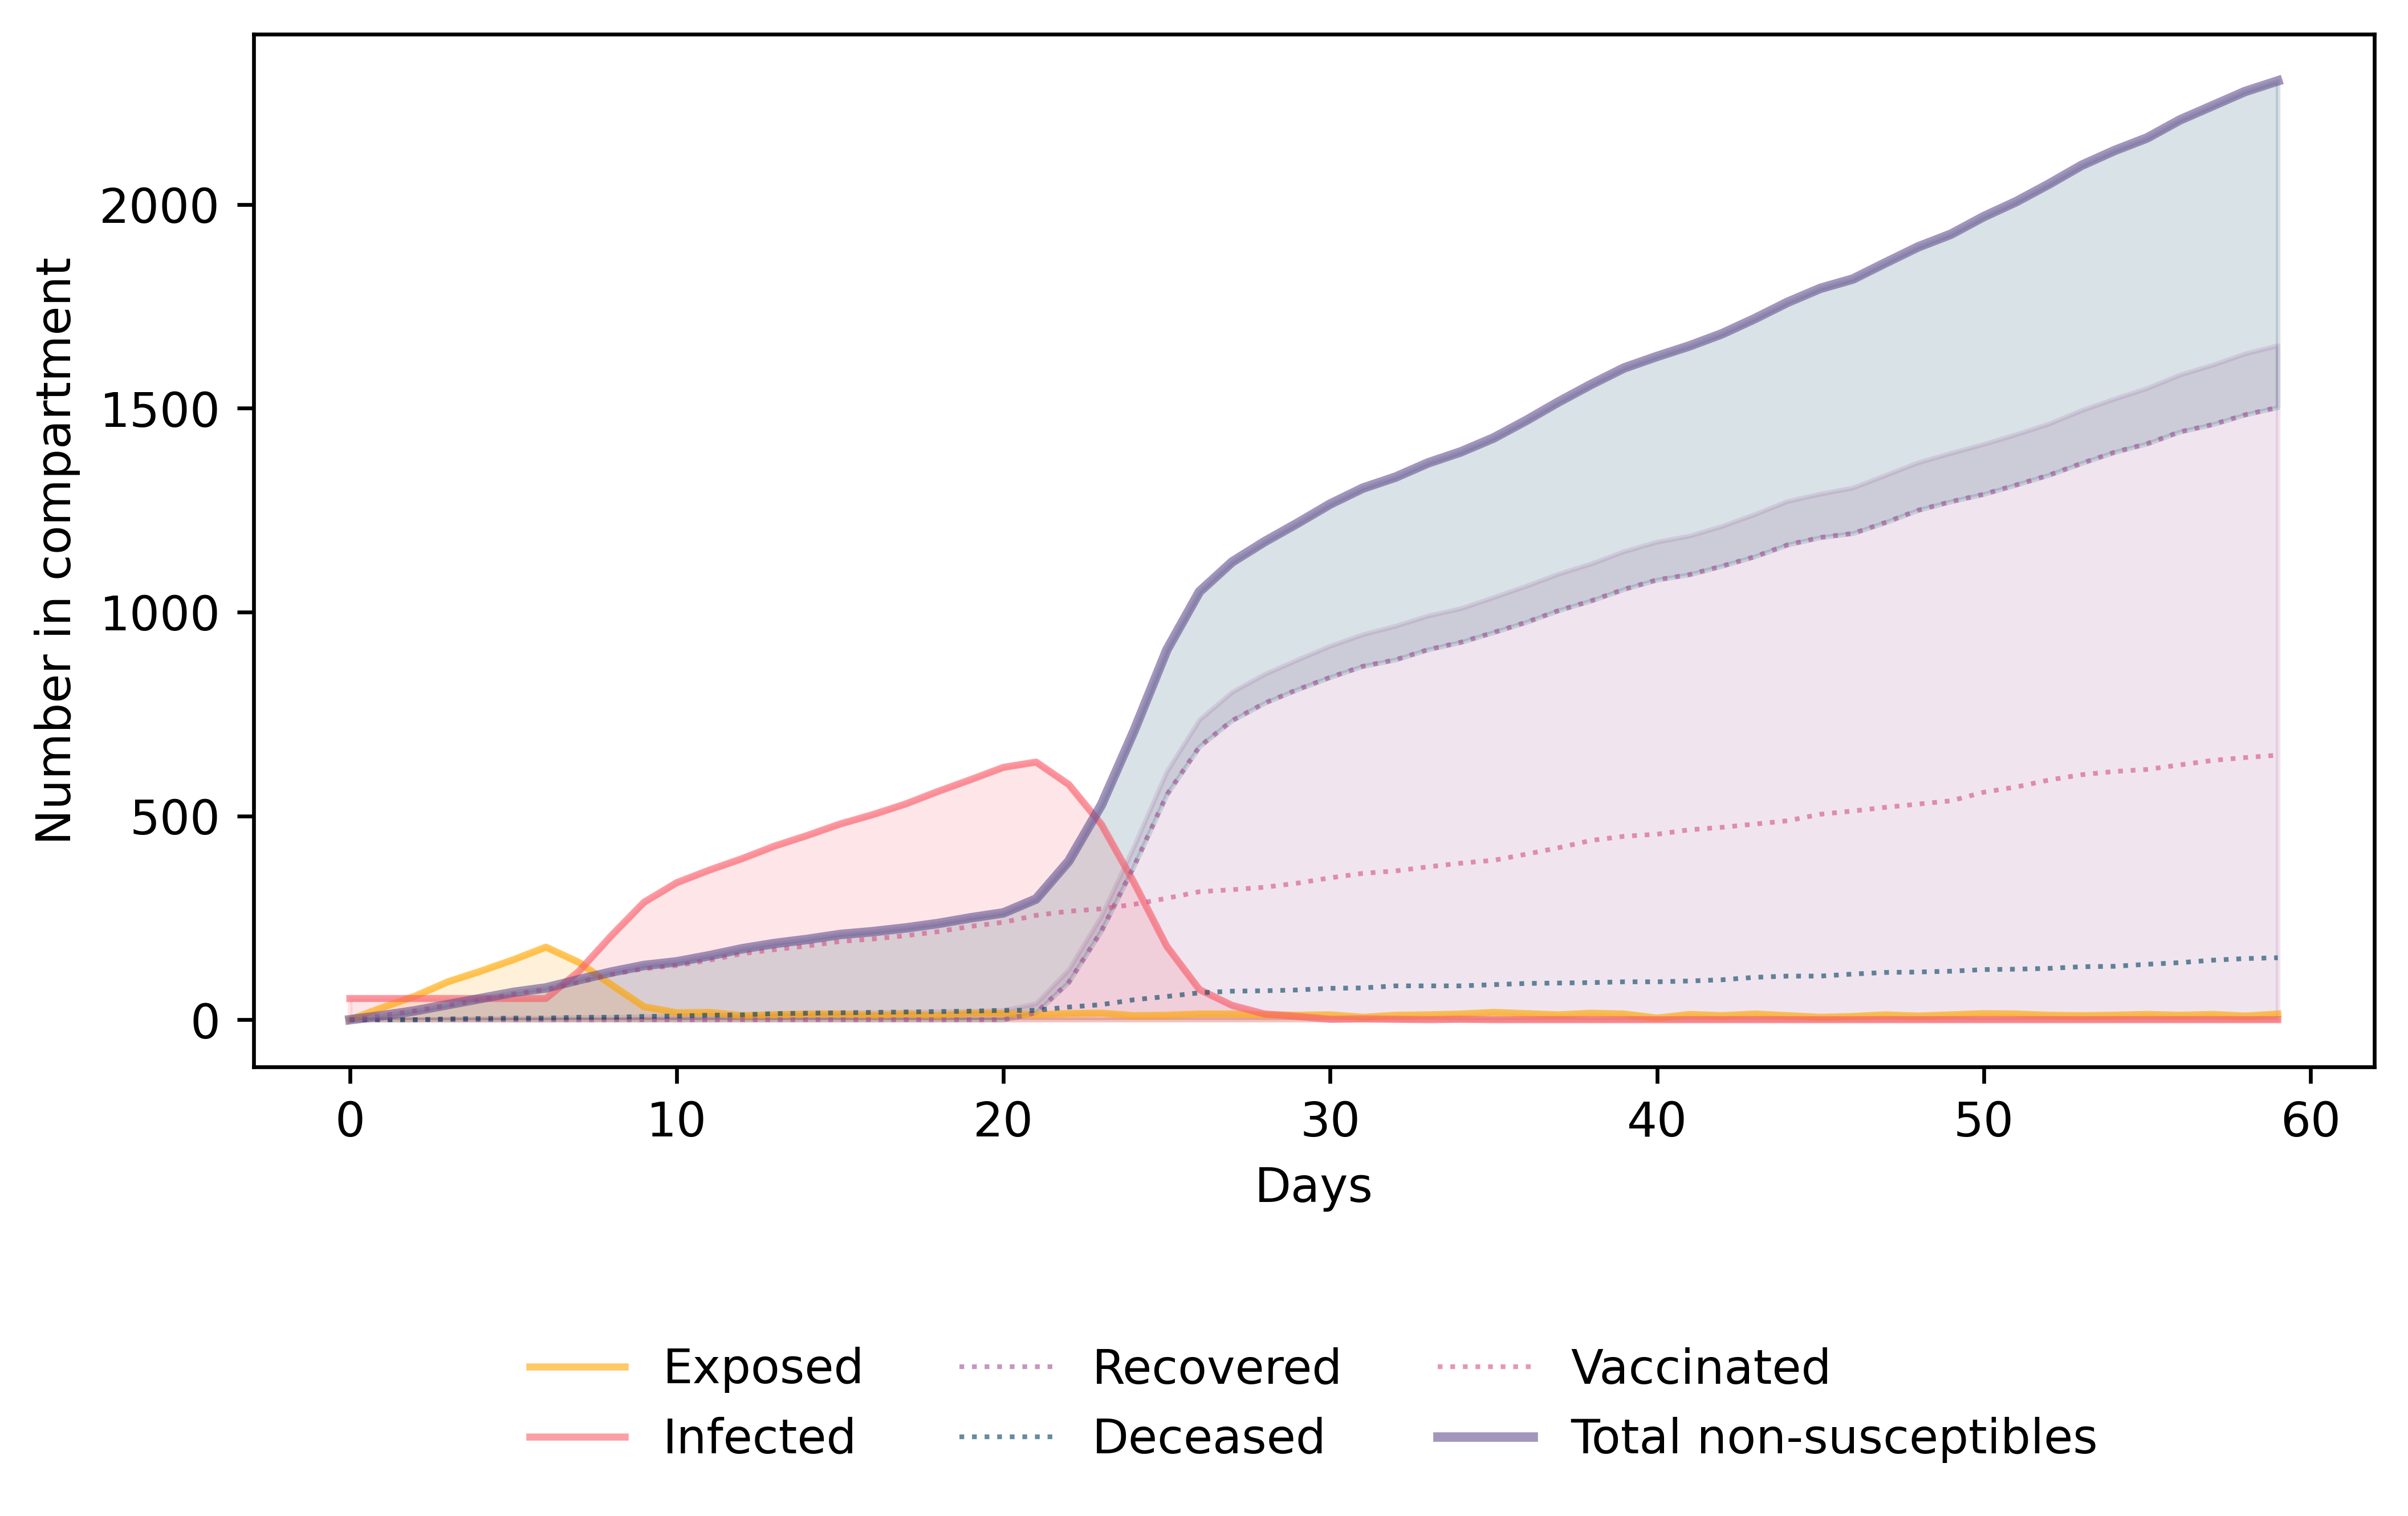

In [8]:
fig = plt.figure(facecolor="w", figsize=(8, 4), dpi=600)
ax = fig.add_subplot(111, axisbelow=True)

# plt.plot(model_results.index, model_results.Susceptible, color=COLORS["S"], label="Susceptible")
ax.plot(model_results.index, model_results.Exposed, color=COLORS["E"], alpha=0.6, label="Exposed")
ax.plot(model_results.index, model_results.Infected, color=COLORS["I"], alpha=0.6, label="Infected")
ax.plot(model_results.index, model_results.Recovered, color=COLORS["R"], alpha=0.6, lw=1, linestyle=":", label="Recovered")
ax.plot(model_results.index, model_results.Deceased, color=COLORS["D"], alpha=0.6, lw=1, linestyle=":", label="Deceased")
ax.plot(model_results.index, model_results.Vaccinated, color=COLORS["Y"], alpha=0.6, lw=1, linestyle=":", label="Vaccinated")
ax.plot(model_results.index, model_results.Recovered + model_results.Deceased + model_results.Vaccinated, color=COLORS["X"], alpha=0.6, lw=2, label="Total non-susceptibles")

ax.fill_between(model_results.index, 0, model_results.Exposed, color=COLORS["E"], alpha=0.15)
ax.fill_between(model_results.index, 0, model_results.Infected, color=COLORS["I"], alpha=0.15)
ax.fill_between(model_results.index, 0, model_results.Recovered + model_results.Deceased, color=COLORS["R"], alpha=0.15)
ax.fill_between(model_results.index, model_results.Recovered, model_results.Recovered + model_results.Deceased + model_results.Vaccinated, color=COLORS["D"], alpha=0.15)


legend = ax.legend()
legend.get_frame().set_alpha(0.5)
plt.legend(title="", bbox_to_anchor=(0.5, -0.425), loc="lower center", ncol=3, frameon=False)

ax.set_xlabel("Days")
ax.set_ylabel("Number in compartment")

plt.savefig("SEIRDV_ABM_output.pdf")